## Analyse Autapse run

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from lfmods.autapse import AutapseSimulator

## Load simulator and indicator of bad data

In [3]:
# simulator
sim = AutapseSimulator(seed=1, pilot_samples=0.,cached_sims=False, cached_pilot=False)
true_params = sim.true_params
n_params = sim.n_params

sim.prior
prior_min = sim.prior_min
prior_max = sim.prior_max
# prior_min = np.array([0.8,0.2])
# prior_max = np.array([2.0,2.5])

init = sim.init
t = sim.t
dt = sim.dt
duration = np.max(t)
I = sim.I_obs

# indicator of bad data
bad_data_indicator = lambda x: int(np.abs(x.reshape(-1)[-1]) > 1000)

#params = np.array([1.1]).reshape(-1,1)
#hh = bm = sim.bm.Autapse(init, params.reshape(1,-1), seed=1)
#states_bad_autapse = hh.sim_time(dt, t, I)[:,0]

#plt.plot(states_good_autapse)
#print(np.mean(states_good_autapse))
#print(np.abs(states_good_autapse[-1]) > 100)
# plt.plot(states_good_autapse)

## State space of model: good vs bad data

/Users/pedro/Documents/repos/likelihoodfree-models/lfmods/autapse_bm.py:35: RuntimeWarning: overflow encountered in double_scalars
  x[i] = x[i-1] + tstep*((J-1)*x[i-1] + I[i-1] + nois_fact*self.rng.randn()/(tstep**0.5))/tau_x


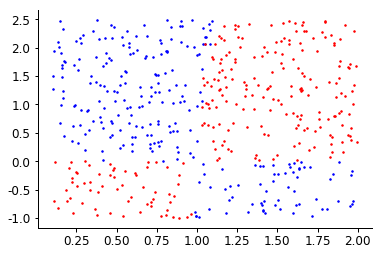

In [4]:
# samples from prior
n_samp = 500
params = sim.prior.gen(n_samp)
gb = np.zeros(n_samp)

for i in range(n_samp):
    autapse = sim.bm.Autapse(init, params[i,:].reshape(1,-1))
    r = autapse.sim_time(dt, t, I)[:,0]
    gb[i] = bad_data_indicator(r)
    
    
plt.plot(params[np.where(gb.astype(int)==0), 0],
         params[np.where(gb.astype(int)==0), 1],'.b')

plt.plot(params[np.where(gb.astype(int)==1), 0],
         params[np.where(gb.astype(int)==1), 1],'.r')
ax = plt.gca()
#ax.set_xticks([0, duration/2, duration])

#A_soma = 1
#ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
plt.show()
# ax.imshow(gb,origin='lower', cmap = cmaps.parula,
#                                         extent=[lims[i, 0],lims[i, 1],lims[j ,0],lims[j ,1]],
#                                         aspect='auto', interpolation='none')

In [19]:
params[np.where(gb.astype(int)==0),0]

array([[ 0.82330965,  0.95699911,  0.85512976,  0.99543901,  1.04384478,
         0.95330991,  1.04164736,  1.00478872,  1.01130758,  0.92838641,
         1.0618279 ,  0.92842013,  0.90919956,  0.88072271,  0.98350369,
         0.88693234,  0.86345153,  0.81645123,  1.02201806,  0.9762858 ,
         0.96183896,  0.90747914,  0.90018274,  0.90375898]])

## Some parameters of the analysis

In [ ]:
# to save or not to save plots
save_plot_flag = 0

###############################################################################
# number of parameters inferred
num_param_inf = 1

###############################################################################
# number of simulations per iteration
sim_step = 100
num_round = 5
num_sim = np.linspace(sim_step, num_round*sim_step, num_round).astype(int)

###############################################################################
# colors
col_original = (35/255,86/255,167/255)
col_lfree = (0, 174/255,239/255)

## Loading files

In [ ]:
# loading filenames, paths and data
iw_loss_ind = 0
prefix = 'autapse_test_iw'
basepath = '../results/autapse/'
dir_nets = basepath + 'nets/'
dir_plots = basepath + 'plots/'

# create folder for plots
if save_plot_flag:
    if not os.path.exists(dir_plots):
        os.makedirs(dir_plots)

###############################################################################
# loading data and posteriors
dists, infos, losses, nets, posteriors, sims = io.load_prefix(dir_nets, prefix)

# data
l_sims = list(sims.items())
obs_stats = l_sims[len(sims)-1][1].obs
y_obs = l_sims[len(sims)-1][1].obs_trace.reshape(-1,1)

# posterior
l_posteriors = list(posteriors.items())
posterior = l_posteriors[len(l_posteriors)-1][1]

###############################################################################
# ground-truth parameters
gt = l_sims[0][1].true_params

###############################################################################
# time
t = l_sims[0][1].t

###############################################################################
# input
I = l_sims[0][1].I_obs
I = I.reshape(1,-1)

## Posterior distribution

In [ ]:
levels=(0.68, 0.95)

alpha_rep = np.linspace(0.5,1,num_rep)

for i in range(len(l_posteriors)):
    
    f, axs = plt.subplots(1,3,figsize=(np.maximum(5,1.5*posterior.ndim),
                                   np.maximum(5,1.5*posterior.ndim)))
    posterior = l_posteriors[i][1]
    for ii in range(posterior.ndim):
        for j in range(ii,posterior.ndim):

            if ii == j:
                ax = plt.subplot2grid((posterior.ndim, posterior.ndim), (ii,j))

                lims = np.array([0.5*gt[ii],1.5*gt[ii]])
                xx = np.linspace(lims[0], lims[1], 500)

                pp = posterior.eval(xx, ii=[ii], log=False)
                ax.plot(xx, pp, lw=1, color=col_lfree)
                ax.vlines(gt[ii], 0, ax.get_ylim()[1], lw=1, color='r')
                
                if ii==0 and j==0:
                    plt.title('round '+str(i+1))

            else:
                ax = plt.subplot2grid((posterior.ndim, posterior.ndim), (ii,j))
                
                lims = np.array([[0.5*gt[ii],1.5*gt[ii]],[0.5*gt[j],
                                  0.5*gt[j]]])

                xx = np.linspace(lims[0, 0], lims[0, 1], 500)
                yy = np.linspace(lims[1 ,0], lims[1, 1], 500)
                X, Y = np.meshgrid(xx, yy)
                xy = np.concatenate([X.reshape([-1, 1]), Y.reshape([-1, 1])], axis=1)

                pp = posterior.eval(xy, ii=[ii, j], log=False)
                pp = pp.reshape(list(X.shape))
                ax.contour(X, Y, viz.probs2contours(pp, levels), levels, lw=1,colors=('w','y'))
                ax.set_xlim(lims[0])
                ax.set_ylim(lims[1])
                ax.plot(gt[ii], gt[j], 'r.', ms=8)
    
    plt.tight_layout()

# save figure
if save_plot_flag == 1:
    plt.savefig(dir_plots + 'fig_summary_lfree_stability' + prefix + '.pdf')
plt.show()

## Training loss

In [ ]:
i=0
for k, v in losses.items():
    i = i+1
    fig, ax = viz.loss(v, title=k)
#     plt.show()
    plt.title('round '+str(i))

## Distance of samples

In [ ]:
for k, v in dists.items():
    fig, ax = viz.dist(v, title=k)

## Validation set

In [ ]:
for i in range(num_round):
    plt.plot(io.nth(losses, i)['val_val'],label='round '+str(i+1))
    plt.ylim([0,20])
plt.legend()

## Importance weights

In [ ]:
f, axs = plt.subplots(1,2,figsize=(15,5))

for i in range(num_round):    
    ax = plt.subplot(1,2,1)
    plt.semilogy(io.nth(losses, i)['trn_out'][-1][1],'.')
    
    ax = plt.subplot(1,2,2)
    plt.hist(io.nth(losses, i)['trn_out'][-1][1],bins=20,log=True,alpha=0.5,label='round '+str(i+1))

plt.legend()

In [ ]:
len(io.nth(losses, i)['trn_out'][-1][1])

## Info

In [ ]:
for k, v in infos.items():
    print(viz.info(v, title=k))